In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip data.zip
!unzip model.zip
!unzip util.zip
!unzip SavedModels.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/downSampledImages/0__20161217_180919_0e30__-122.4580609636931_37.76252989470461_downSampled.png  
  inflating: data/downSampledImages/0__20161218_180844_0e26__-122.25570705681058_37.844651758189976_downSampled.png  
  inflating: data/downSampledImages/0__20161218_180844_0e26__-122.36110169563392_37.8090383704882_downSampled.png  
  inflating: data/downSampledImages/0__20161218_180844_0e26__-122.44292051246497_37.86017914204665_downSampled.png  
  inflating: data/downSampledImages/0__20161218_180844_0e26__-122.48871932039954_37.84589395485927_downSampled.png  
  inflating: data/downSampledImages/0__20161218_180844_0e26__-122.5253411209817_37.835177499797524_downSampled.png  
  inflating: data/downSampledImages/0__20161218_180844_0e26__-122.52802558191966_37.84727481184221_downSampled.png  
  inflating: data/downSampledImages/0__20161218_180845_0e26__-122.33170129781017_37.785080771313474_downSampled.png  
  inflating: 

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import utils
import skimage.color as sc
import cv2
import os
import pandas as pd
import skimage.measure
from data.CustomDataset import imageDataset
from torch.utils.data import DataLoader
from torchvision import transforms as T
from model import esrt
import torch.nn.functional as F

In [5]:
ANNOTATIONS = 'data/metadata/test.csv'
GT_DIRECTORY = 'data/shipsDataset/scenes/scenes/'
LEARNING_RATE = 2e-4
SCALE = 2
STEP_SIZE = 200
GAMMA = 0.5
TEST_BATCH_SIZE = 1
PATCH_SIZE = 40
isY = True
N_COLOURS = 3
RGB_RANGE = 1
DATE = "13_Jun"
MODEL = "Vanilla_ESRT"
OUTPUT_FOLDER = "Test_Outputs/{}/{}/{}x/".format(MODEL, DATE, SCALE)
MODEL_DICT = 'SavedModels/{}/{}/{}x/epoch_100.pth'.format(MODEL, DATE ,SCALE)
upscaled_patch_size = PATCH_SIZE * SCALE
OVERLAP = 10

In [6]:
imname = "sfbay_1.png"
original_image = cv2.imread(GT_DIRECTORY + imname, cv2.IMREAD_COLOR)[:, :, [2, 1, 0]]
im_input = original_image / 255.0
im_input = np.transpose(im_input, (2, 0, 1))
im_input = im_input[np.newaxis, ...]
im_input = torch.from_numpy(im_input).float()


In [7]:
def chop_image_into_patches(image_tensor, patch_size, overlap):
    patches = []
    _, c, h, w = image_tensor.shape
    stride = patch_size - overlap
    for i in range(0, h - overlap, stride):
        for j in range(0, w - overlap, stride):
            patch = image_tensor[:, :, i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return patches, stride

# Function to apply super-resolution to a patch
def super_resolve_patch(patch, model):
    # Apply the super-resolution model (replace this with your actual model inference)
    # Example: super_resolved_patch = model(patch)
    # Here, we use a dummy operation for illustration
    with torch.no_grad():
        super_resolved_patch = model(patch)
    return super_resolved_patch

# Function to reconstruct image from super-resolved patches
def reconstruct_image_from_patches(patches, padded_shape, original_shape, patch_size, stride, upscale_factor):
    _, c, h, w = padded_shape
    _, orig_c, orig_h, orig_w = original_shape
    reconstructed_image = torch.zeros((1, c, h * upscale_factor, w * upscale_factor))
    weight = torch.zeros_like(reconstructed_image)
    patch_size_up = patch_size * upscale_factor
    stride_up = stride * upscale_factor

    index = 0
    for i in range(0, h * upscale_factor - (patch_size_up - stride_up), stride_up):
        for j in range(0, w * upscale_factor - (patch_size_up - stride_up), stride_up):
            reconstructed_image[:, :, i:i+patch_size_up, j:j+patch_size_up] += patches[index]
            weight[:, :, i:i+patch_size_up, j:j+patch_size_up] += 1
            index += 1

    # Average overlapping areas
    reconstructed_image /= weight

    # Remove padding
    reconstructed_image = reconstructed_image[:, :, :orig_h * upscale_factor, :orig_w * upscale_factor]
    return reconstructed_image



In [8]:
# Function to pad image tensor to be divisible by patch size
def pad_image(image_tensor, patch_size, overlap):
    _, _, h, w = image_tensor.shape
    stride = patch_size - overlap
    pad_h = (stride - h % stride) % stride
    pad_w = (stride - w % stride) % stride
    padded_image = F.pad(image_tensor, (0, pad_w, 0, pad_h), mode='reflect')
    return padded_image



In [9]:
if torch.cuda.is_available():
        device = "cuda"
else:
        device = "cpu"
print(f"using {device}")

using cuda


In [10]:
#Load model
model =  esrt.ESRT(upscale = SCALE)
model_dict = utils.load_state_dict(MODEL_DICT, torch.cuda.is_available())
model.load_state_dict(model_dict, strict=False)#True)

scale 0.16666666666666666
288
36


In [11]:
padded_im_input = pad_image(im_input, PATCH_SIZE, OVERLAP)

In [12]:
# Step 2: Chop image into patches
patches, stride = chop_image_into_patches(padded_im_input, PATCH_SIZE, OVERLAP)

In [13]:
# Step 3: Apply super-resolution to each patch
super_resolved_patches = [super_resolve_patch(patch,model) for patch in patches]

In [14]:
# Step 5: Reconstruct the final super-resolved image
super_resolved_image = reconstruct_image_from_patches(super_resolved_patches, padded_im_input.shape, im_input.shape, PATCH_SIZE, stride, SCALE,)

In [15]:
super_resolved_image = utils.tensor2np(super_resolved_image.detach()[0])

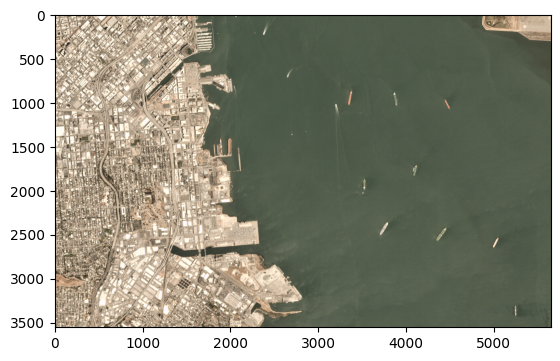

In [16]:
fig = plt.imshow(super_resolved_image)

In [17]:
cv2.imwrite("sfbay_1_SR.png", super_resolved_image[:, :, [2, 1, 0]])

True